<All keys matched successfully>


/media/HDD1/zihui/SAMG/sam_hq/segment_anything/utils/amg.py:118: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  change_indices = diff.nonzero()


18
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


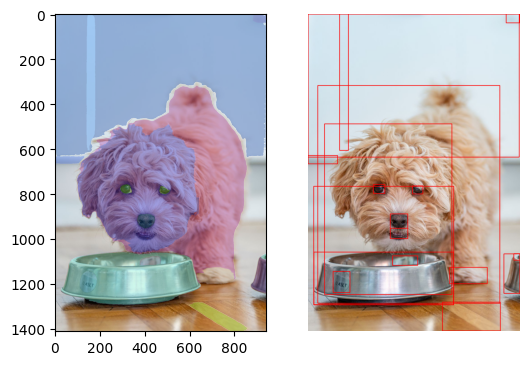

In [2]:
import cv2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from sam_hq.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "assets/sam_hq_vit_b.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# image = cv2.imread('assets/color_image.png')
image = cv2.imread('assets/rgb.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())
plt.figure(figsize=(6,6))

plt.subplot(1, 2, 1)
plt.imshow(image)
show_anns(masks)

plt.subplot(1, 2, 2)
for mask in masks:
    x, y, w, h = np.array(mask['bbox']).astype(int)
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(image)


plt.axis('off')
plt.show() 

In [6]:
for mask in masks:
    print(mask['bbox'], mask['segmentation'].shape, mask['area'])    

[11.0, 178.0, 88.0, 155.0] (390, 506) 5560
[325.0, 146.0, 180.0, 84.0] (390, 506) 6817
[443.0, 321.0, 62.0, 68.0] (390, 506) 1710
[154.0, 279.0, 41.0, 42.0] (390, 506) 1019
[236.0, 96.0, 58.0, 82.0] (390, 506) 3428
[397.0, 233.0, 41.0, 34.0] (390, 506) 1257
[174.0, 165.0, 62.0, 35.0] (390, 506) 1944
[372.0, 266.0, 68.0, 65.0] (390, 506) 2425
[173.0, 165.0, 63.0, 104.0] (390, 506) 1958
[201.0, 283.0, 85.0, 79.0] (390, 506) 1275
[200.0, 282.0, 28.0, 27.0] (390, 506) 439
[346.0, 240.0, 49.0, 44.0] (390, 506) 1893
[181.0, 167.0, 7.0, 14.0] (390, 506) 87
[372.0, 289.0, 34.0, 18.0] (390, 506) 217
[68.0, 116.0, 35.0, 26.0] (390, 506) 360
[187.0, 314.0, 41.0, 44.0] (390, 506) 1068
[476.0, 358.0, 29.0, 31.0] (390, 506) 508
[224.0, 308.0, 62.0, 54.0] (390, 506) 1217
[31.0, 108.0, 88.0, 85.0] (390, 506) 4311
[386.0, 289.0, 20.0, 18.0] (390, 506) 195
[129.0, 225.0, 76.0, 64.0] (390, 506) 526
[65.0, 149.0, 9.0, 9.0] (390, 506) 77
[67.0, 117.0, 52.0, 76.0] (390, 506) 1376
[329.0, 212.0, 67.0, 73.0] 

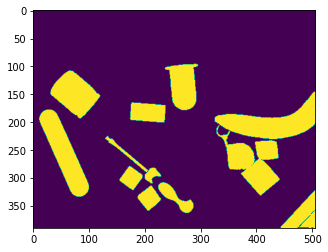

In [7]:
seg_mask = np.zeros_like(masks[0]['segmentation'])
for mask in masks:
    seg_mask += mask['segmentation']
    if mask['area'] > 10000:
        continue
plt.imshow(seg_mask)

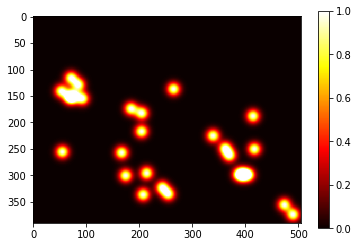

In [8]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

def generate_gaussian_heatmap(center, shape, sigma):
    x = np.arange(0, shape[1], 1, float)  # 从0到width的数列
    y = np.arange(0, shape[0], 1, float)[:, np.newaxis]  # 从0到height的数列
    x0, y0 = center
    heatmap = np.exp(-4*np.log(2) * ((x - x0)**2 + (y - y0)**2) / sigma**2)
    return heatmap

def generate_heatmap_image(image_shape, boxes, sigma=10):
    heatmap = np.zeros(image_shape, dtype=np.float32)
    
    for box in boxes:
        x1, y1, w, h = box
        center = (x1 + w / 2, y1 + h / 2)  # 计算中心点坐标
        heatmap += generate_gaussian_heatmap(center, image_shape, sigma)
    
    heatmap = np.clip(heatmap, 0, 1)
    return heatmap

# 示例图像形状
image_shape = (390, 506)

# 给定的点
points = []
for mask in masks:
    x, y, w, h = np.array(mask['bbox']).astype(int)
    points.append([x,y,w,h])

# 生成热力图
heatmap = generate_heatmap_image(image_shape, points, sigma=20)

# 可视化热力图
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


In [7]:
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [5]:
import cv2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from sam_hq.segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "assets/sam_hq_vit_b.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

<All keys matched successfully>


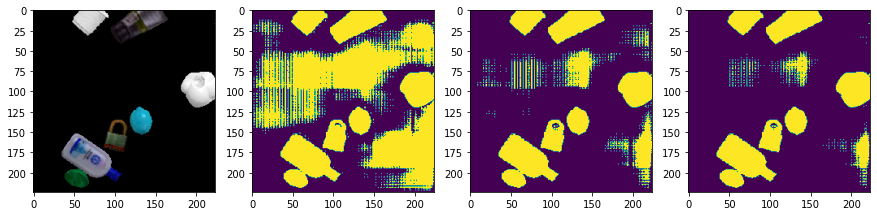

In [30]:
image = cv2.imread('assets/color_image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)


# draw center points
# for point in center_points:
#     cv2.circle(image, (point[0], point[1]), 2, (255, 0, 0), -1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(image)

for idx, num_grids in enumerate([16, 32, 64]):
    center_points = []

    interval = 224 // num_grids

    for i in range(num_grids):
        for j in range(num_grids):
            center_points.append([i*interval+interval//2, j*interval+interval//2])
    center_points = np.array(center_points)
    # x = np.linspace(0, 224, num_grids).astype(int)
    # y = np.linspace(0, 224, num_grids).astype(int)
    # print(x, y)

    # center_points = np.array([[i, j] for i in x for j in y])
    if num_grids == 1:
        center_points = np.array([[111, 111]])
    masks, scores, logits = predictor.predict(
            point_coords=center_points,
            point_labels=[1 for _ in range(len(center_points))],
            # box=np.array([56, 56, 112, 112]),
            multimask_output=False,
        )

    plt.subplot(1, 4, 2+idx)
    plt.imshow(masks[0])

(224, 224, 1) bool
(84, 84) float32


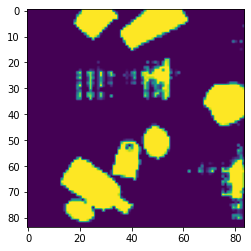

In [31]:
masks = masks.transpose(1, 2, 0)
print(masks.shape, masks.dtype)
masks = np.float32(masks)
masks = cv2.resize(masks, (84, 84))
print(masks.shape, masks.dtype)
plt.imshow(masks)

0.13016592 3.896484e-05


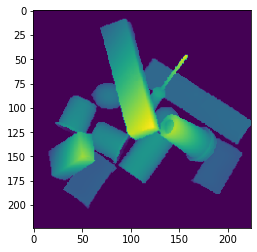

In [10]:
depth_image = np.load('assets/depth_image.npy')
plt.imshow(depth_image)
print(np.max(depth_image), np.min(depth_image))
depth_image = (depth_image - np.min(depth_image)) / (np.max(depth_image) - np.min(depth_image))
depth_image = np.where(depth_image > 0, 1, 0)

In [2]:
image = cv2.imread('assets/color_image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
center_points = []
num_grids = 32
interval = 224 // num_grids

for i in range(num_grids):
    for j in range(num_grids):
        center_points.append([i*interval+interval//2, j*interval+interval//2])
center_points = np.array(center_points)

# see if the depth of the center points is 1
# depth = depth_image[center_points[:, 0], center_points[:, 1]]
# center_points = center_points[depth == 1]
print(center_points.shape)
predictor.set_image(image)
masks, scores, logits = predictor.predict(
        point_coords=center_points,
        point_labels=[1 for _ in range(len(center_points))],
        multimask_output=False,
    )
plt.imshow(masks[0])

NameError: name 'cv2' is not defined

In [11]:
import pickle
import numpy as np

# read the pickle file
with open('datasets/episode_0.pkl', 'rb') as f:
    data = pickle.load(f)

In [12]:
data.keys()

dict_keys(['rgb_images', 'depth_images', 'grasp_poses', 'grasp_labels'])

In [18]:
for (pos, label) in zip(data['grasp_poses'], data['grasp_labels']):
    print(pos.shape, label)

(22, 7) [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 1. 7. 7. 7. 7. 7.]
(21, 7) [7. 7. 1. 7. 7. 7. 7. 7. 7. 0. 7. 0. 0. 7. 7. 7. 7. 7. 7. 7. 7.]
(11, 7) [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 1.]
(6, 7) [7. 7. 7. 7. 7. 1.]
(10, 7) [7. 7. 7. 7. 7. 1. 7. 7. 7. 7.]
(6, 7) [7. 7. 7. 7. 1. 7.]
(7, 7) [7. 7. 7. 7. 7. 1. 7.]
(5, 7) [0. 0. 7. 7. 0.]
(7, 7) [0. 7. 7. 1. 7. 7. 7.]
(6, 7) [7. 7. 7. 7. 1. 7.]
(4, 7) [0. 7. 7. 0.]
(1, 7) [0.]
(14, 7) [7. 7. 1. 7. 7. 0. 7. 7. 7. 7. 7. 7. 7. 7.]
(2, 7) [1. 7.]
(2, 7) [7. 0.]


: 

In [2]:
import glob

len(glob.glob('datasets/mixed/*1_objs.pkl'))

1000

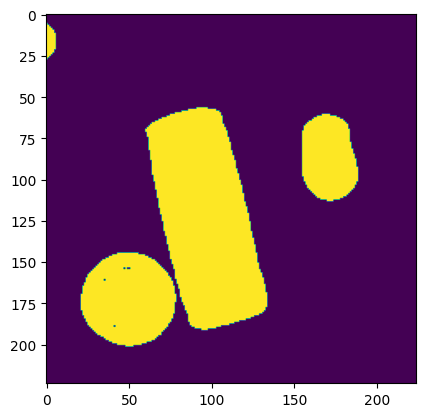

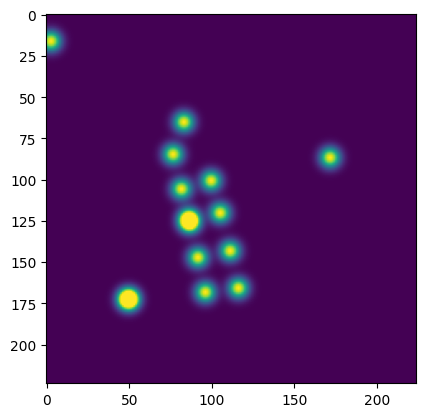

In [9]:
import numpy as np
import matplotlib.pyplot as plt

masks = np.load('datasets/mixed/episode_642781_4_objs_masks.npz', allow_pickle=True)
plt.imshow(masks['seg_mask'])
plt.show()
plt.imshow(masks['heightmap'])
plt.show()

In [1]:
import glob
import tqdm
import numpy as np

for num_obj in range(1, 11):
    count = 0
    for pkl_file in tqdm.tqdm(glob.glob(f"datasets/mixed/trajs/*{num_obj}_objs.pkl")):
        data = np.load(pkl_file, allow_pickle=True)
        count += len(data['samples']['success_indices'])
    print(num_obj, count)

100%|██████████| 1000/1000 [00:05<00:00, 172.82it/s]


1 3678


100%|██████████| 1000/1000 [00:06<00:00, 161.58it/s]


2 4211


100%|██████████| 1000/1000 [00:07<00:00, 126.03it/s]


3 4664


100%|██████████| 1000/1000 [00:06<00:00, 159.58it/s]


4 4761


100%|██████████| 1000/1000 [00:05<00:00, 169.94it/s]


5 5321


100%|██████████| 1000/1000 [00:05<00:00, 169.47it/s]


6 6042


100%|██████████| 1000/1000 [00:06<00:00, 165.60it/s]


7 6120


100%|██████████| 1000/1000 [00:06<00:00, 159.62it/s]


8 6232


100%|██████████| 1000/1000 [00:06<00:00, 143.58it/s]


9 6820


100%|██████████| 1000/1000 [00:06<00:00, 153.41it/s]

10 6894


In [2]:
'episode_642781_4_objs.pkl'.split('_')

['episode', '642781', '4', 'objs.pkl']

In [3]:
for i in range(0, 10, 2):
    print(i)

0
2
4
6
8


In [9]:
10000 / 1024

9.765625

In [10]:
10000 - 9*1024

784